In [1]:
# This notebook illustrates handling the July 2024 Demo of the 6mo Hackathon Scenario 2, described at: https://github.com/DARPA-ASKEM/program-milestones/issues/74

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd

RESOURCES = "../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-07")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "SEIRHD_vacc_petrinet.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "SEIRHD_vacc_petrinet_request.json"
)

request_params = {}

# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario
STATES = ["S_u", "I_u", "E_u", "S_v", "E_v", "I_v", "H", "R", "D"]

MAX_TIME=28
STEP_SIZE=7
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

In [3]:
# Helper functions to setup FUNMAN for different steps of the scenario

def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False):
    # Overrides for configuration
    #
    funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = 1000
    # funman_request.config.verbosity = 10
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False):
    to_synthesize = get_synthesized_vars(funman_request)
    return Runner().run(
        MODEL_PATH,
        funman_request,
        description="SEIRHD Hackathon 6mo",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )

def setup_common(funman_request, synthesize=False, debug=False):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug)
    

def set_compartment_bounds(funman_request, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=STATES, additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        ax = df[STATES].plot()
        ax.set_yscale("log")

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name):
    plot_last_point(results)
    param_values = get_last_point_parameters(results)
    print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    pretty_print_request_params(request_params)

Automatic initialization of gaol... done
[9830000.00000, 9830000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.30000, 0.30000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-07-24 18:45:00,403 - funman.api.run - INFO - Dumping results to ./out/30859b53-7cf9-40f3-8066-675251190783.json
2024-07-24 18:45:06,166 - funman.scenario.consistency - INFO - 4{28}:	[+]
2024-07-24 18:45:06,177 - funman.server.worker - INFO - Completed work on: 30859b53-7cf9-40f3-8066-675251190783
2024-07-24 18:45:10,451 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-07-24 18:45:10,710 - funman.server.worker - INFO - FunmanWorker exiting...
2024-07-24 18:45:10,711 - funman.server.worker - INFO - Worker.stop() completed.


1 points
Point parameters: {'N': 9830000.0, 'NPI_mult': 1.0, 'beta': 0.15249999999999997, 'vacc_mult': 0.30000000000000004, 'r_Sv': 10000.0, 'r_SvSu': 0.002, 'r_EI': 0.13160484699686698, 'r_IH_u': 0.00435, 'r_IH_v': 0.0013499999999999999, 'r_HR': 0.17341744342913468, 'r_HD': 0.011, 'r_IR_u': 0.185, 'r_IR_v': 0.185}
                       N  NPI_mult    beta      r_EI   r_HD      r_HR  \
unconstrained  9830000.0       1.0  0.1525  0.131605  0.011  0.173417   

                r_IH_u   r_IH_v  r_IR_u  r_IR_v     r_Sv  r_SvSu  vacc_mult  
unconstrained  0.00435  0.00135   0.185   0.185  10000.0   0.002        0.3  


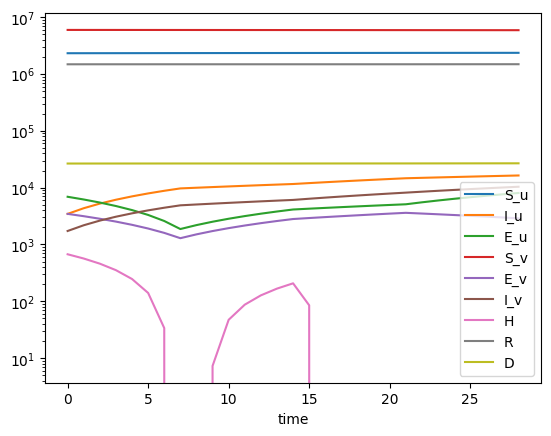

In [4]:
# Find a single parameterization of the model that allows H <= 3000 for all timepoints.
# Do not assume the default compartmental constraints because model has vital dynamics.
# The chosen parameters result in an impossibly large value for some compartments.
# Further runs need to eliminate these impossible values.

funman_request = get_request()
setup_common(funman_request)
results = run(funman_request)
report(results, "unconstrained")

2024-07-24 18:45:11,106 - funman.server.worker - INFO - FunmanWorker running...
2024-07-24 18:45:11,109 - funman.server.worker - INFO - Starting work on: 4fb6b7ce-21b0-4f02-b255-eb94134dba6d
[9830000.00000, 9830000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.30000, 0.30000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-07-24 18:45:18,791 - funman.api.run - INFO - Dumping results to ./out/4fb6b7ce-21b0-4f02-b255-eb94134dba6d.json
2024-07-24 18:45:18,804 - funman.scenario.consistency - INFO - 4{28}:	[+]
2024-07-24 18:45:18,818 - funman.server.worker - INFO - Completed work on: 4fb6b7ce-21b0-4f02-b255-eb94134dba6d
2024-07-24 18:45:28,831 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-07-24 18:45:28,900 - funman.server.worker - INFO - FunmanWorker exiting...
2024-07-24 18:45:28,902 - funman.server.worker - INFO - 

1 points
Point parameters: {'N': 9830000.0, 'NPI_mult': 1.0, 'beta': 0.15250000000000002, 'vacc_mult': 0.30000000000000004, 'r_Sv': 10000.0, 'r_SvSu': 0.002, 'r_EI': 0.1508337675718892, 'r_IH_u': 0.00435, 'r_IH_v': 0.00135, 'r_HR': 0.1549189131819147, 'r_HD': 0.011, 'r_IR_u': 0.185, 'r_IR_v': 0.185}
                                   N  NPI_mult    beta  vacc_mult     r_Sv  \
unconstrained              9830000.0       1.0  0.1525        0.3  10000.0   
compartmental_constrained  9830000.0       1.0  0.1525        0.3  10000.0   

                           r_SvSu      r_EI   r_IH_u   r_IH_v      r_HR  \
unconstrained               0.002  0.131605  0.00435  0.00135  0.173417   
compartmental_constrained   0.002  0.150834  0.00435  0.00135  0.154919   

                            r_HD  r_IR_u  r_IR_v  
unconstrained              0.011   0.185   0.185  
compartmental_constrained  0.011   0.185   0.185  


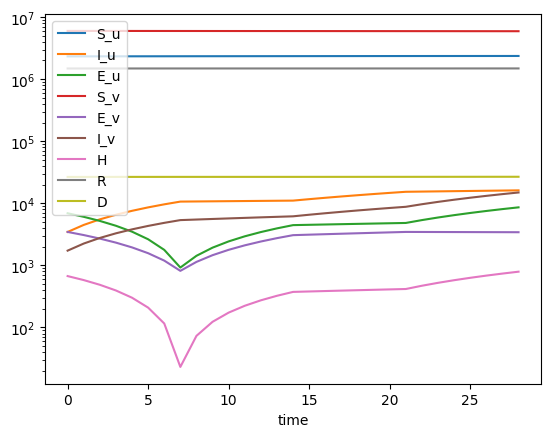

In [5]:
# Add bounds [0, N] to the STATE compartments.  
# Add bounds sum(STATE) in [N-e, N+e], for a small e.

funman_request = get_request()
setup_common(funman_request, debug=True)
set_compartment_bounds(funman_request)
results = run(funman_request)
report(results, "compartmental_constrained")

2024-07-24 18:45:29,268 - funman.server.worker - INFO - FunmanWorker running...
2024-07-24 18:45:29,271 - funman.server.worker - INFO - Starting work on: ecbf77a9-062b-4470-b67f-48928653308b
[9830000.00000, 9830000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.30000, 0.30000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-07-24 18:45:35,834 - funman.api.run - INFO - Dumping results to ./out/ecbf77a9-062b-4470-b67f-48928653308b.json
2024-07-24 18:45:35,855 - funman.scenario.consistency - INFO - 4{28}:	[+]
2024-07-24 18:45:35,867 - funman.server.worker - INFO - Completed work on: ecbf77a9-062b-4470-b67f-48928653308b
2024-07-24 18:45:45,875 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-07-24 18:45:45,919 - funman.server.worker - INFO - FunmanWorker exiting...
2024-07-24 18:45:45,924 - funman.server.worker - INFO - 

1 points
Point parameters: {'N': 9830000.0, 'NPI_mult': 1.0, 'beta': 0.15239796545843914, 'vacc_mult': 0.30000000000000004, 'r_Sv': 10000.0, 'r_SvSu': 0.002, 'r_EI': 0.14105188985883776, 'r_IH_u': 0.004350000000000001, 'r_IH_v': 0.00135, 'r_HR': 0.14635253130970075, 'r_HD': 0.011, 'r_IR_u': 0.185, 'r_IR_v': 0.185}
                                   N  NPI_mult      beta  vacc_mult     r_Sv  \
unconstrained              9830000.0       1.0  0.152500        0.3  10000.0   
compartmental_constrained  9830000.0       1.0  0.152500        0.3  10000.0   
relaxed_bounds             9830000.0       1.0  0.152398        0.3  10000.0   

                           r_SvSu      r_EI   r_IH_u   r_IH_v      r_HR  \
unconstrained               0.002  0.131605  0.00435  0.00135  0.173417   
compartmental_constrained   0.002  0.150834  0.00435  0.00135  0.154919   
relaxed_bounds              0.002  0.141052  0.00435  0.00135  0.146353   

                            r_HD  r_IR_u  r_IR_v  
unconstrain

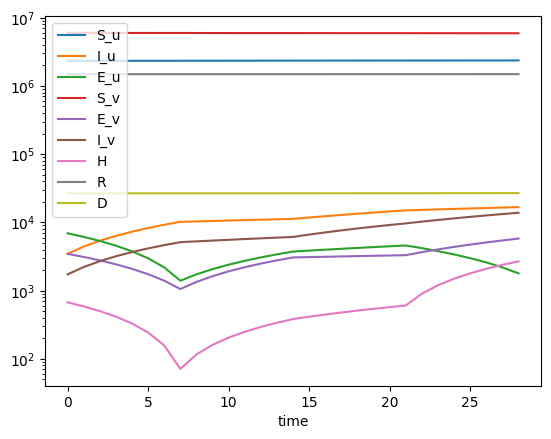

In [6]:
# Relax the bounds on the parameters to allow additional parameterizations

funman_request = get_request()
setup_common(funman_request)
set_compartment_bounds(funman_request)
relax_parameter_bounds(funman_request, factor = 0.75)
results = run(funman_request)
report(results, "relaxed_bounds")

2024-07-24 18:45:46,223 - funman.server.worker - INFO - FunmanWorker running...
2024-07-24 18:45:46,225 - funman.server.worker - INFO - Starting work on: a654ce35-3219-47bc-9515-4acdbed918ea
[9830000.00000, 9830000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.30000, 0.30000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-07-24 18:45:48,239 - funman.api.run - INFO - Dumping results to ./out/a654ce35-3219-47bc-9515-4acdbed918ea.json
2024-07-24 18:46:11,345 - funman.api.run - INFO - Dumping results to ./out/a654ce35-3219-47bc-9515-4acdbed918ea.json
2024-07-24 18:46:11,366 - funman.search.box_search - INFO - progress: 0.20000
2024-07-24 18:46:11,384 - funman.api.run - INFO - Creating plot of point trajectories: ./out/a654ce35-3219-47bc-9515-4acdbed918ea_points.png
2024-07-24 18:46:11,418 - funman.search.box_search - INFO - progress: 0.40000
2024

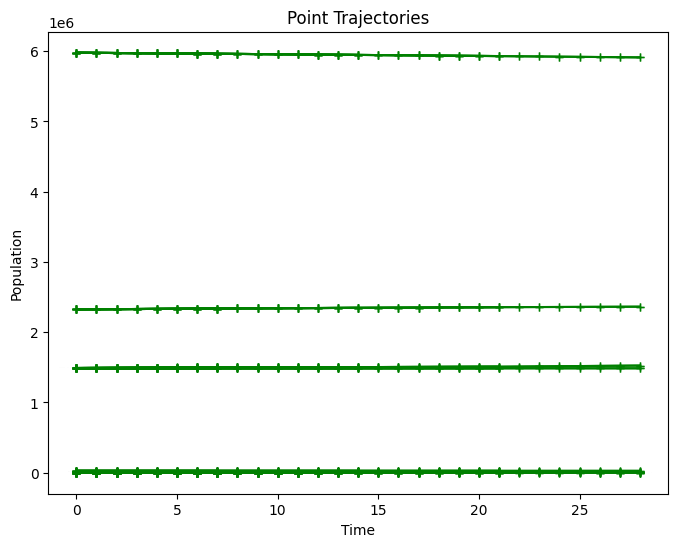

2024-07-24 18:46:11,728 - funman.api.run - INFO - Creating plot of parameter space: ./out/a654ce35-3219-47bc-9515-4acdbed918ea_parameter_space.png
2024-07-24 18:46:12,675 - funman.server.worker - INFO - Completed work on: a654ce35-3219-47bc-9515-4acdbed918ea


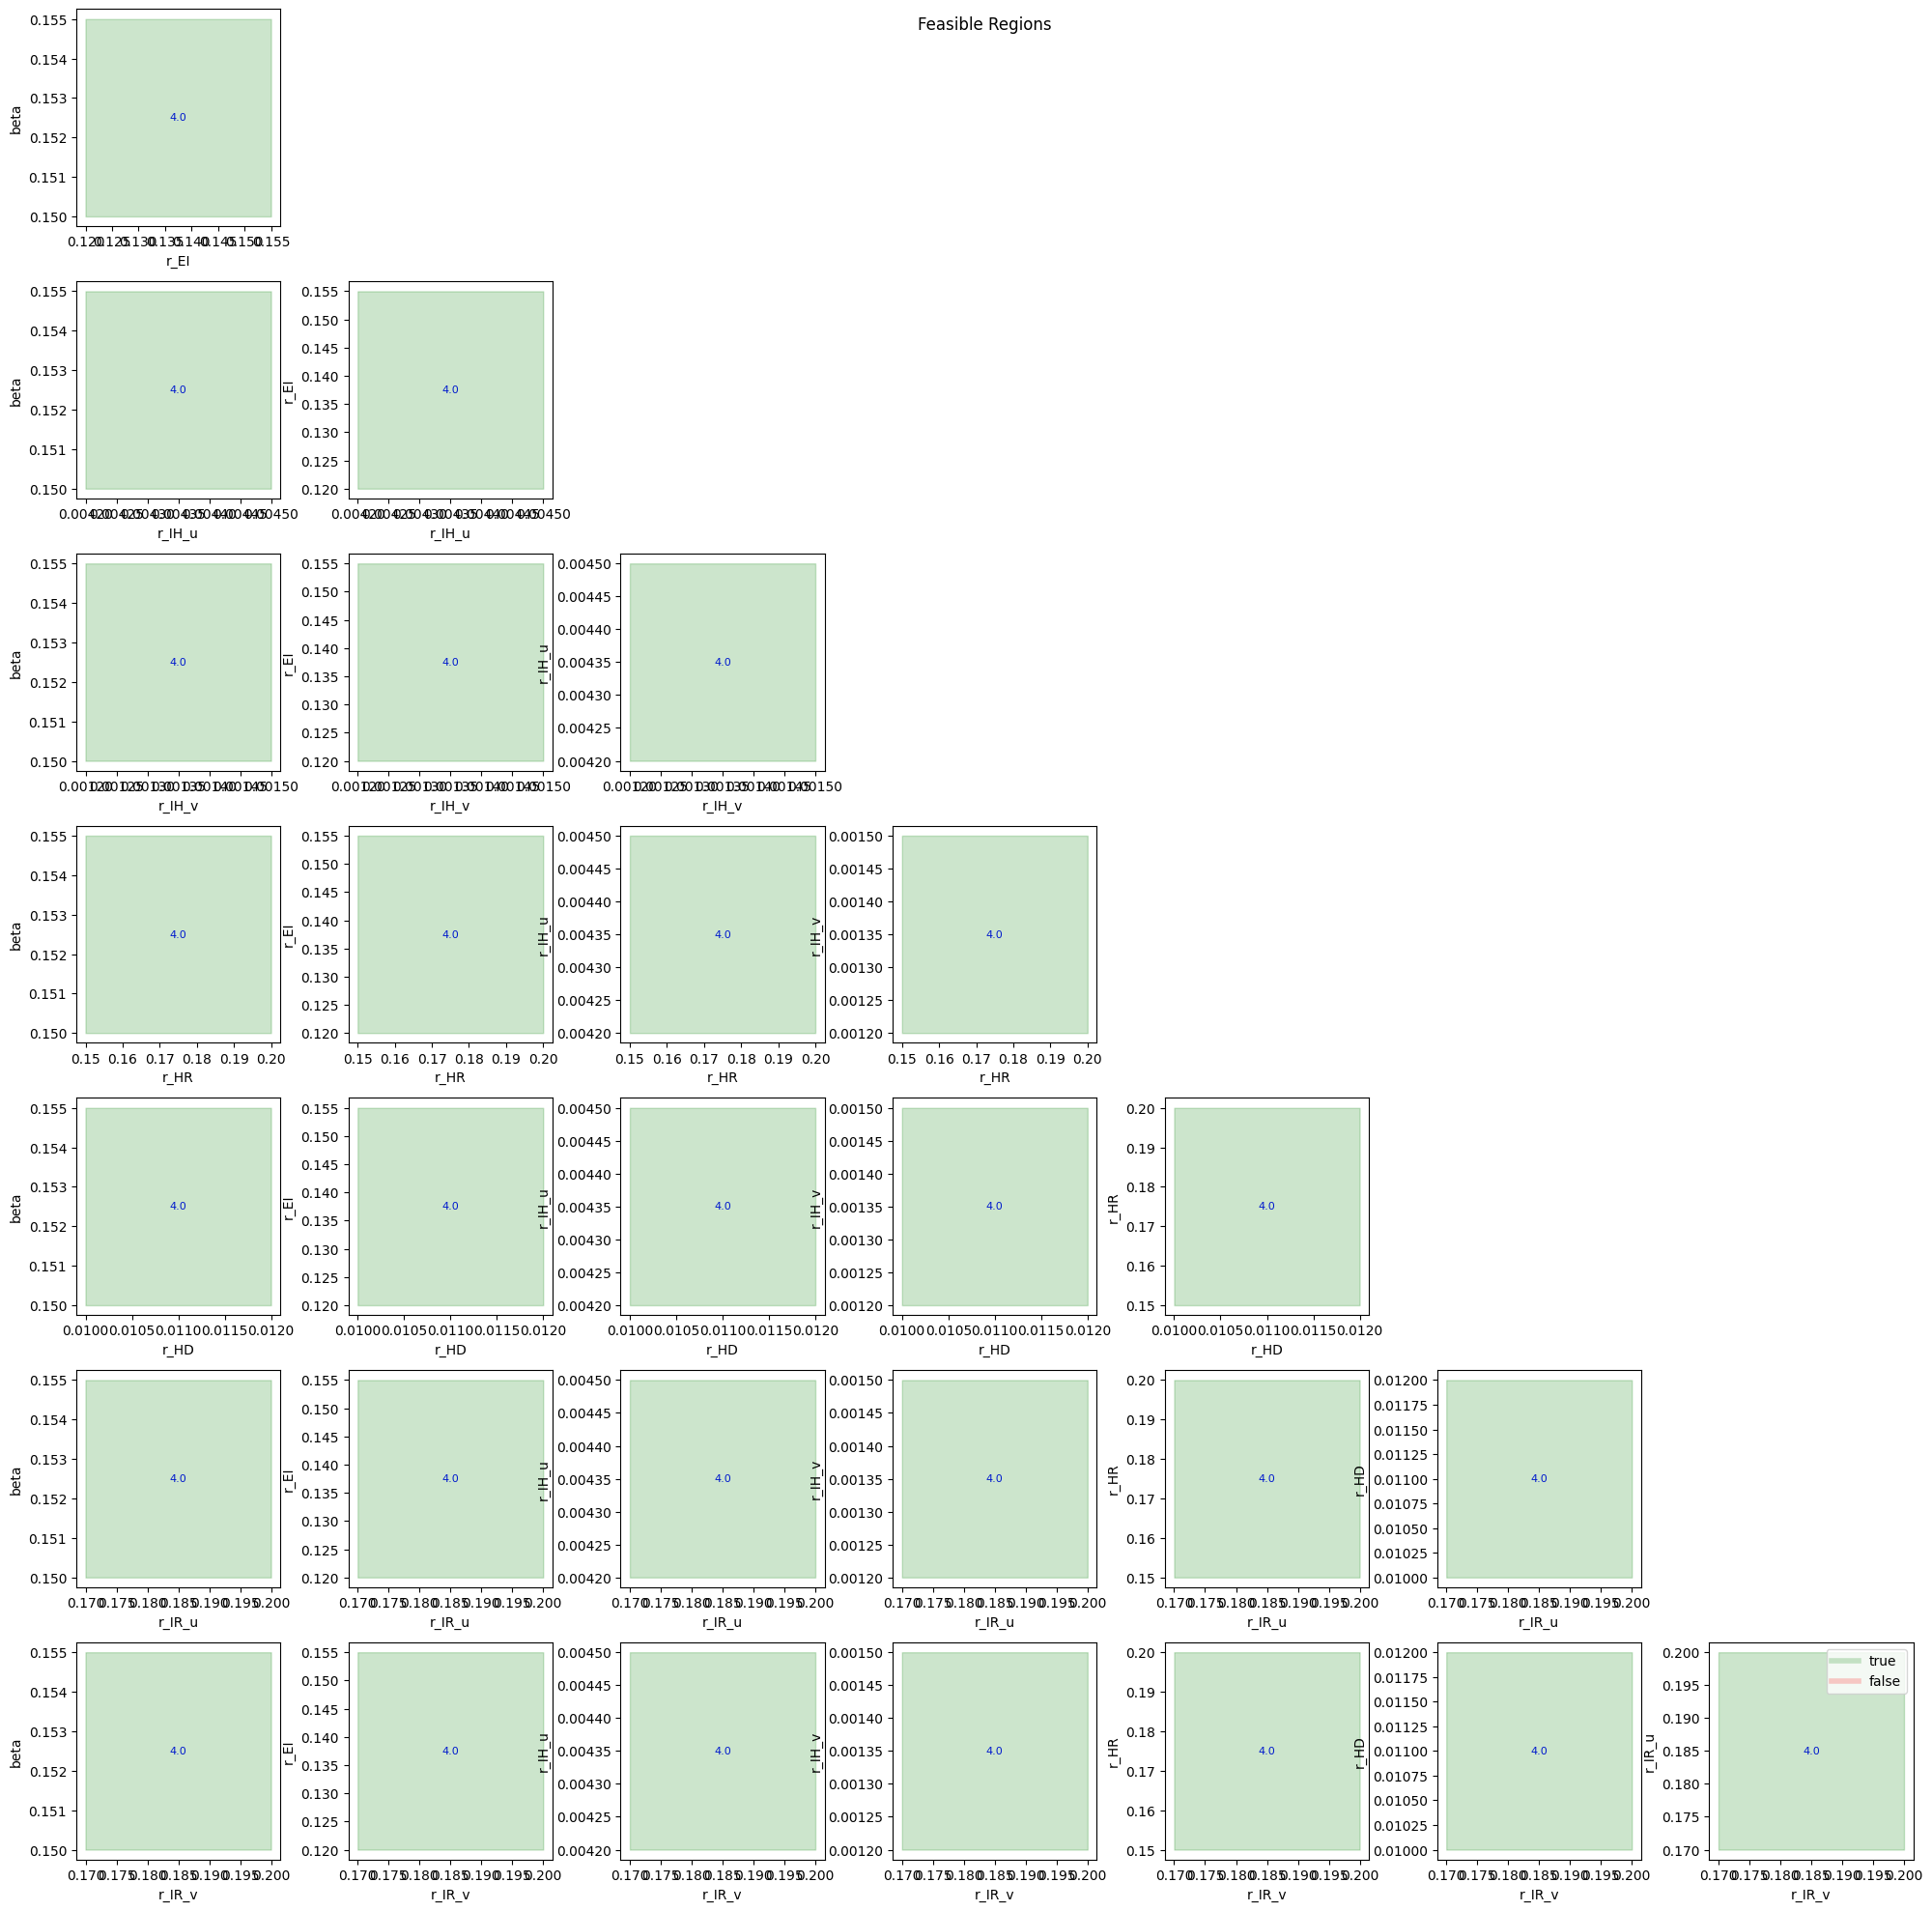

2024-07-24 18:46:24,876 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-07-24 18:46:25,277 - funman.server.worker - INFO - FunmanWorker exiting...
2024-07-24 18:46:25,279 - funman.server.worker - INFO - Worker.stop() completed.


5 points
Point parameters: {'N': 9830000.0, 'NPI_mult': 1.0, 'vacc_mult': 0.30000000000000004, 'r_Sv': 10000.0, 'r_SvSu': 0.002, 'beta': 0.15250000000000002, 'r_EI': 0.14691128985675908, 'r_IH_u': 0.00435, 'r_IH_v': 0.00135, 'r_HR': 0.1549189131819147, 'r_HD': 0.011, 'r_IR_u': 0.185, 'r_IR_v': 0.185}
                                   N  NPI_mult      beta  vacc_mult     r_Sv  \
unconstrained              9830000.0       1.0  0.152500        0.3  10000.0   
compartmental_constrained  9830000.0       1.0  0.152500        0.3  10000.0   
relaxed_bounds             9830000.0       1.0  0.152398        0.3  10000.0   
synthesis                  9830000.0       1.0  0.152500        0.3  10000.0   

                           r_SvSu      r_EI   r_IH_u   r_IH_v      r_HR  \
unconstrained               0.002  0.131605  0.00435  0.00135  0.173417   
compartmental_constrained   0.002  0.150834  0.00435  0.00135  0.154919   
relaxed_bounds              0.002  0.141052  0.00435  0.00135  0.146353 

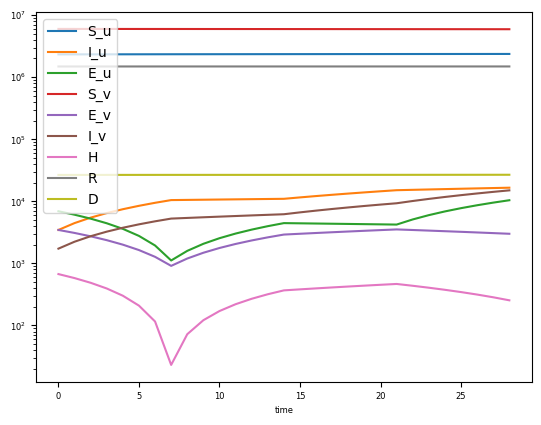

In [7]:
funman_request = get_request()
setup_common(funman_request, synthesize=True)
set_compartment_bounds(funman_request)
# relax_parameter_bounds(funman_request, factor=0.75)
# funman_request.config.verbosity=10
results = run(funman_request, plot=True)
report(results, "synthesis")

In [8]:
# import pandas as pd
# df1 = pd.DataFrame({"ltp": ltp, "gtp": gtp})

# # df2 = 
# # df1.ltp.N == df1.gtp.N
# # df2.loc[df2].sort_index()[0:60]

# #(= H_10 (+ H_8 (* 2 (+ (* r_HD (- 1) H_8) (* r_HR (- 1) H_8) (* r_IH_v I_v_8) (* r_IH_u I_u_8)))))

# df1['same'] = df1['ltp'] == df1["gtp"]
# df1[0:20]
# # df1.loc[df1.index.str.endswith("_6")].sort_values(by="same")

In [9]:
# # Get points (trajectories generated)
# pts = results.parameter_space.points() 
# print(f"{len(pts)} points")

# # Get a plot for last point
# df = results.dataframe(points=pts[-1:])
# ax = df[STATES].plot()
# ax.set_yscale("log")


# # Get the values of the point
# gtp=pts[-1].values


# # Output the model diagram
# #
# # results_unconstrained_point.model.to_dot()
# # gtp